In [1]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "whitegrid")

In [2]:
con=sqlite3.connect('imdb.db')

In [3]:
c=con.cursor()

In [4]:
tabelas= pd.read_sql_query("SELECT NAME AS 'Table_name' FROM sqlite_master WHERE type='table'",con)

In [5]:
tabelas.head()

,Table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [8]:
tabelas=tabelas["Table_name"].values.tolist()

In [10]:
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, con)
    print("Esquema da tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




In [11]:
consulta1='''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [12]:
resultado1=pd.read_sql_query(consulta1,con)

In [13]:
display(resultado1)

,type,COUNT
0,movie,609282
1,short,868084
2,tvEpisode,6679344
3,tvMiniSeries,43289
4,tvMovie,135970
5,tvPilot,2
6,tvSeries,224546
7,tvShort,10526
8,tvSpecial,36818
9,video,260111


In [14]:
resultado1['percentual']=(resultado1['COUNT']/resultado1['COUNT'].sum())*100

In [15]:
display(resultado1)

,type,COUNT,percentual
0,movie,609282,6.846601
1,short,868084,9.754802
2,tvEpisode,6679344,75.056880
3,tvMiniSeries,43289,0.486446
4,tvMovie,135970,1.527917
5,tvPilot,2,0.000022
6,tvSeries,224546,2.523260
7,tvShort,10526,0.118282
8,tvSpecial,36818,0.413730
9,video,260111,2.922910


In [16]:
others={}
others['COUNT']= resultado1[resultado1['percentual'] <5]['COUNT'].sum()
others['percentual']= resultado1[resultado1['percentual'] <5]['percentual'].sum()
others['type']='others'

In [17]:
others

{'COUNT': 742333, 'percentual': 8.341717193635315, 'type': 'others'}

In [18]:
resultado1=resultado1[resultado1['percentual'] >5]

In [19]:
resultado1=resultado1.append(others, ignore_index=True)

In [21]:
resultado1= resultado1.sort_values(by='COUNT', ascending=False)

In [22]:
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6679344,75.056880
1,short,868084,9.754802
3,others,742333,8.341717
0,movie,609282,6.846601


In [24]:
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

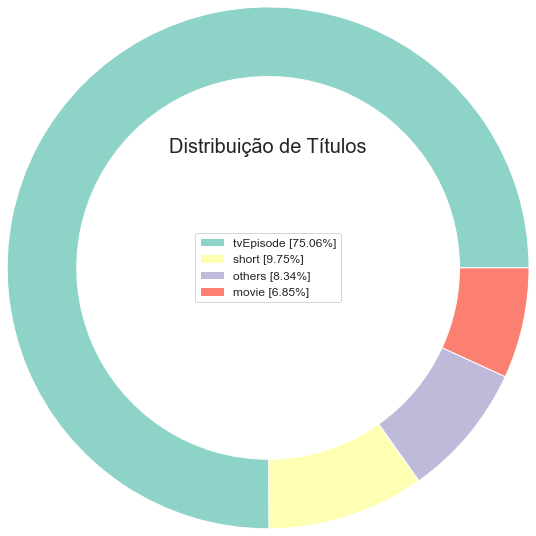

In [25]:
cs= cm.Set3(np.arange(100))
f= plt.figure()
#plot do gráfico
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Títulos", loc = 'Center', fontdict = {'fontsize':20,'fontweight':20})
plt.show()

In [26]:
resultado2= '''SELECT genres, COUNT(*) FROM titles WHERE type='movie' GROUP BY genres'''

In [27]:
resultado2= pd.read_sql_query(resultado2,con)

In [28]:
display(resultado2)

,genres,COUNT(*)
0,Action,14008
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1457,"Thriller,Western",43
1458,War,1294
1459,"War,Western",14
1460,Western,5154


In [29]:
resultado2['genres']= resultado2['genres'].str.lower().values

In [30]:
temp=resultado2['genres'].dropna()

In [31]:
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [32]:
bag_generos= vetor.transform(temp)

In [33]:
generos_unicos= vetor.get_feature_names()

In [34]:
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [35]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1462 entries, 0 to 1461
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1462 non-null   int64
 1   adult        1462 non-null   int64
 2   adventure    1462 non-null   int64
 3   animation    1462 non-null   int64
 4   biography    1462 non-null   int64
 5   comedy       1462 non-null   int64
 6   crime        1462 non-null   int64
 7   documentary  1462 non-null   int64
 8   drama        1462 non-null   int64
 9   family       1462 non-null   int64
 10  fantasy      1462 non-null   int64
 11  film-noir    1462 non-null   int64
 12  game-show    1462 non-null   int64
 13  history      1462 non-null   int64
 14  horror       1462 non-null   int64
 15  music        1462 non-null   int64
 16  musical      1462 non-null   int64
 17  mystery      1462 non-null   int64
 18  n            1462 non-null   int64
 19  news         1462 non-null   int64
 20  reality-

In [36]:
generos = generos.drop(columns = 'n', axis = 0)

In [37]:
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [39]:
generos_percentual.head(10)

drama          18.057456
comedy         16.826265
documentary    15.800274
adventure      14.842681
action         14.432285
romance        13.269494
crime          13.132695
mystery        12.517100
thriller       12.311902
fantasy        12.106703
dtype: float64

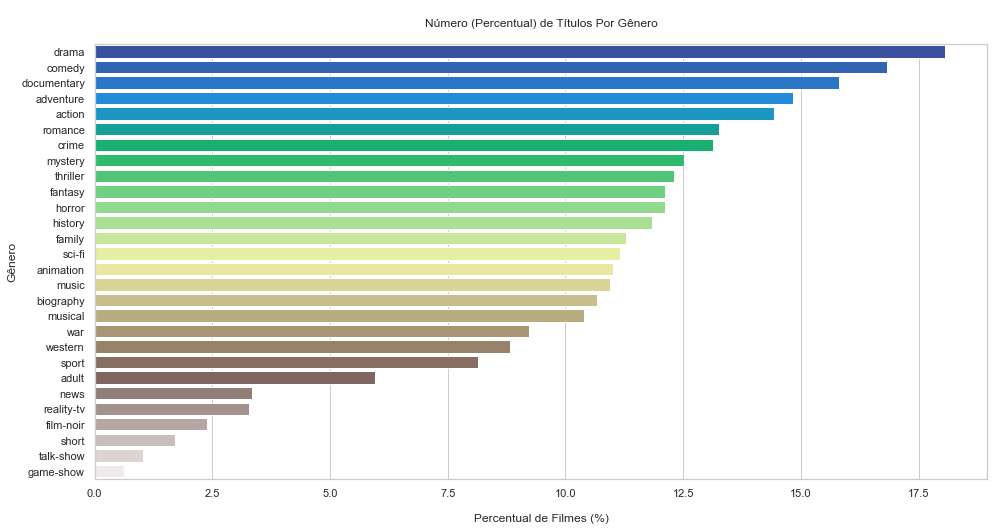

In [40]:
plt.figure(figsize = (16,8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = "h", palette = "terrain")
plt.ylabel('Gênero')             
plt.xlabel("\nPercentual de Filmes (%)")
plt.title('\nNúmero (Percentual) de Títulos Por Gênero\n')
plt.show()